In [2]:
import pandas as pd

#df1 = pd.read_excel("./data/anon_WMSPick20250101_03.xlsx") # Slechte data: timestamps kloppen niet
df2 = pd.read_excel("./data/anon_WMSPick20250104_06.xlsx")
df3 = pd.read_excel("./data/anon_WMSPick20250107_09.xlsx")
#df4 = pd.read_excel("./data/anon_WMSPick20250110_12.xlsx") # idem
df5 = pd.read_excel("./data/anon_WMSPick20250113_15.xlsx")
df6 = pd.read_excel("./data/anon_WMSPick20250116_19.xlsx")

dfs=[df2,df3,df5,df6]
df=pd.concat(dfs)
df = df[df['Out in'] != 'Outgoing']

weights_df = pd.read_excel("./data/anon_Inventory_20241231.xlsx")


In [3]:
inventory_info_df = pd.read_excel("./data/anon_Inventory_20241231.xlsx")
inventory_info_df

,Warehouse zone code,Weight(item),Gross weight,Weight(stock Product),Volume(stock Product),Item code,Abc Code(item),Container code,Container Size Code(container),Top level container code,Location code,Inventory Qty,Replenishment Zone Code,Qty On Picklist,Parent container code,Product code7,Product location group code
0,MINILOAD,30,3600,30,314,0,B,4436,H1,4436,BUMINI1,120,MINILOAD,0,04436,NaN,REGULIER
1,MINILOAD,35,4200,35,216,1,B,14251,H1,14251,BUMINI1,120,MINILOAD,0,14251,NaN,REGULIER
2,MINILOAD,23,2760,23,216,2,B,14410,H1,14410,BUMINI1,120,MINILOAD,0,14410,NaN,REGULIER
3,MINILOAD,35,4200,35,216,3,B,16098,H1,16098,BUMINI1,120,MINILOAD,0,16098,NaN,REGULIER
4,MINILOAD,27,3240,27,314,4,B,36395,H1,36395,BUMINI1,120,MINILOAD,0,36395,NaN,REGULIER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113229,MANPICK,50,-850,50,840,13218,E,17134,H1,17134,ZU08B,13,PISLOW,0,17134,NaN,SARDA
113230,MANPICK,25,-1350,25,528,12020,E,7210,H1,7210,ZU08C,6,PISLOW,0,07210,NaN,SARDA
113231,MANPICK,25,-1150,25,528,28352,E,74672,H1,74672,ZU09A,14,PISLOW,0,74672,NaN,SARDA
113232,MANPICK,120,-840,120,1875,1408,E,92304,H1,92304,ZU10C,3,PISLOW,0,92304,NaN,REGULIER


In [4]:

df['Creation Dt'] = pd.to_datetime(df['Creation Dt'].astype(float), origin='1899-12-30', unit='D')
df['Last Change Dt'] = pd.to_datetime(df['Last Change Dt'].astype(float), origin='1899-12-30', unit='D')

#print(df.dtypes)
#print(df.head())

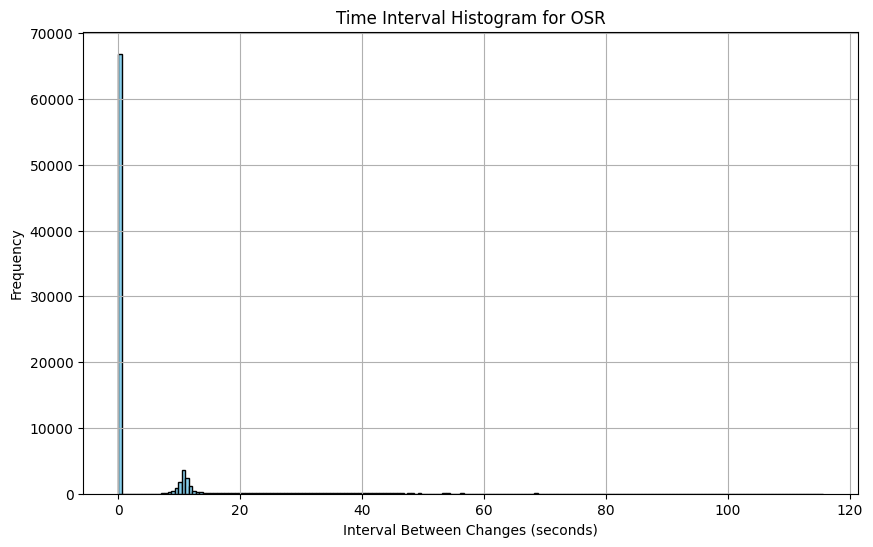

In [5]:
import matplotlib.pyplot as plt
loc = 'OSR'

# Step 1: Filter to just Picklist line number 1
loc_df = df[df['Location code'] == loc].sort_values(by='Last Change Dt')

# Step 2: Compute time differences
loc_df['Time Delta'] = loc_df['Last Change Dt'].diff()

# Step 3: Convert to seconds for plotting
loc_df['Delta Seconds'] = loc_df['Time Delta'].dt.total_seconds()

# Calculate lower and upper bounds using quantiles
upper_bound = loc_df['Delta Seconds'].quantile(0.99)

# Filter out outliers
filtered_intervals = loc_df['Delta Seconds'][
    (loc_df['Delta Seconds'] <= upper_bound) &
    (loc_df['Delta Seconds'] >= 0)
]

# Step 4: Drop NaN (first diff will be NaN) and plot
plt.figure(figsize=(10, 6))
plt.hist(filtered_intervals.dropna(), bins=200, color='skyblue', edgecolor='black')
plt.title('Time Interval Histogram for OSR')
plt.xlabel('Interval Between Changes (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Location code
OSR           86370
PTL-NEST14    10256
PTL-NEST12     9957
PTL-NEST26     9941
PTL-NEST21     9078
PTL-NEST23     9068
PTL-NEST13     8534
PTL-NEST15     7855
PTL-NEST16     7801
PTL-NEST25     7724
PTL-NEST24     7447
PTL-NEST11     7318
PTL-NEST22     7175
PACK           1712
BAK04C         1622
BAK04A         1585
BAK04B         1539
BAK04D         1308
BAK08B         1284
BAK08D         1116
Name: count, dtype: int64


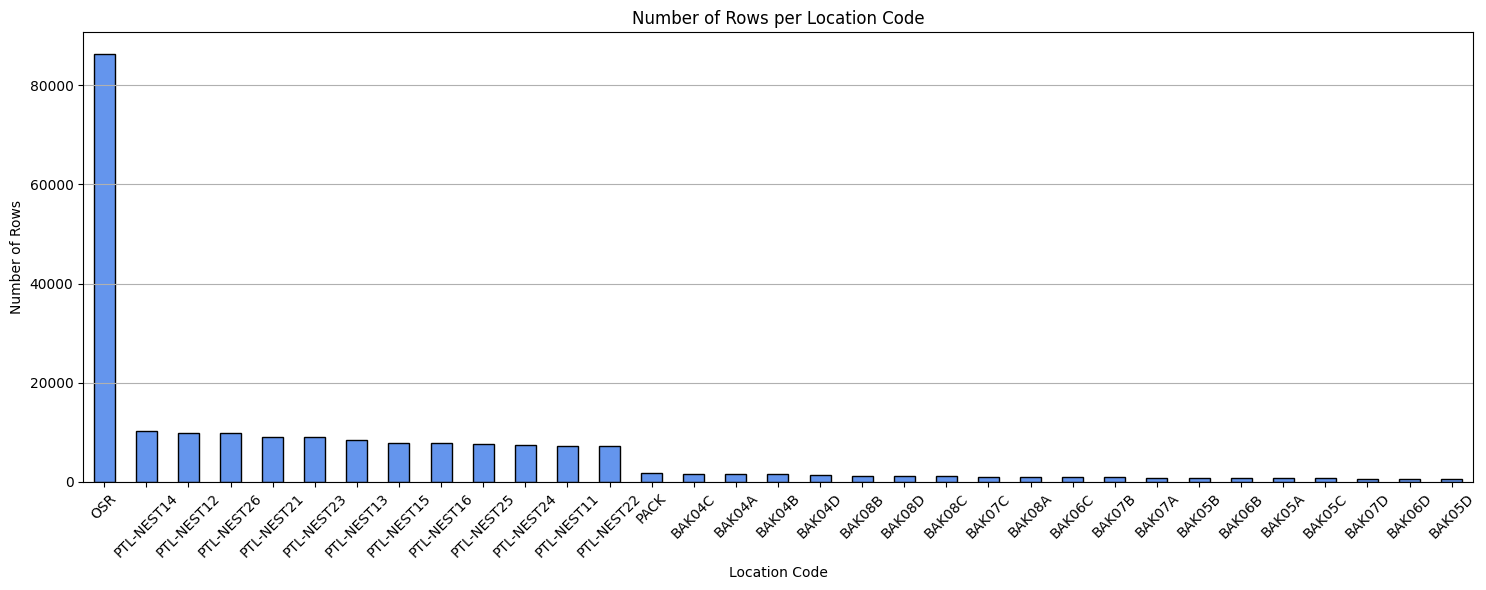

In [14]:
container_count = df['Location code'].value_counts()
container_count = container_count[container_count >= 500]  # Keep only counts ≥ 3

print(container_count.head(20))
# Step 2: Plot
plt.figure(figsize=(15, 6))
container_count.plot(kind='bar', color='cornflowerblue', edgecolor='black')

# Step 3: Beautify
plt.title('Number of Rows per Location Code')
plt.xlabel('Location Code')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

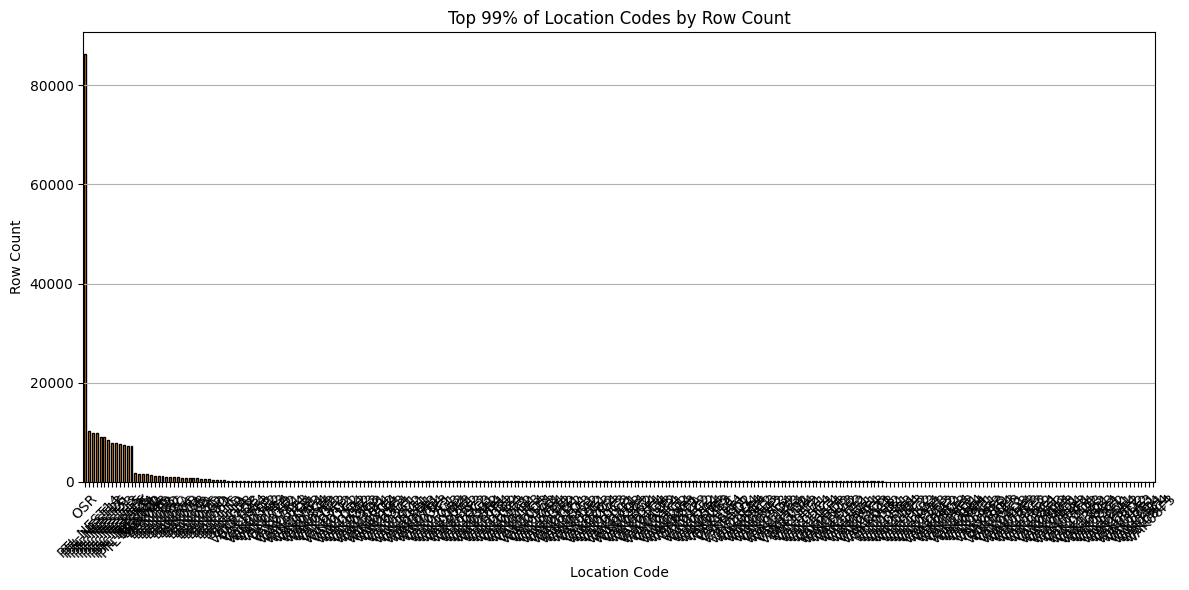

277 location codes make up 99% of the data.


In [15]:
# Step 1: Count rows per Location code
location_counts = df['Location code'].value_counts()

# Step 2: Calculate cumulative percentage
cumulative_percent = location_counts.cumsum() / location_counts.sum()

# Step 3: Filter to keep only the top 99%
top_99 = location_counts[cumulative_percent <= 0.99] #57% voor de top 13, OSR is de grootste (37%)

# Step 4: Plot
plt.figure(figsize=(12, 6))
top_99.plot(kind='bar', color='darkorange', edgecolor='black')

plt.title('Top 99% of Location Codes by Row Count')
plt.xlabel('Location Code')
plt.ylabel('Row Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
print(f"{len(top_99)} location codes make up 99% of the data.")


In [16]:
# Step 1: Compute time deltas per Location code
df_sorted = df.sort_values(by=['Location code', 'Last Change Dt'])
df_sorted['Time Delta'] = df_sorted.groupby('Location code')['Last Change Dt'].diff()

# Step 2: Convert to seconds
df_sorted['Delta Seconds'] = df_sorted['Time Delta'].dt.total_seconds()

# Step 3: Drop NaNs (first of each group) and group
mean_estimates = df_sorted.groupby('Location code')['Delta Seconds'].mean().dropna()

# Step 4: Convert mean intervals to Poisson λ
lambda_per_location = 1 / mean_estimates

print(lambda_per_location.head())


Location code
AEPACK02P    0.000001
AEPACK03P    0.000010
APACK01P     0.000002
APACK02P     0.000370
APACK03P     0.000007
Name: Delta Seconds, dtype: float64


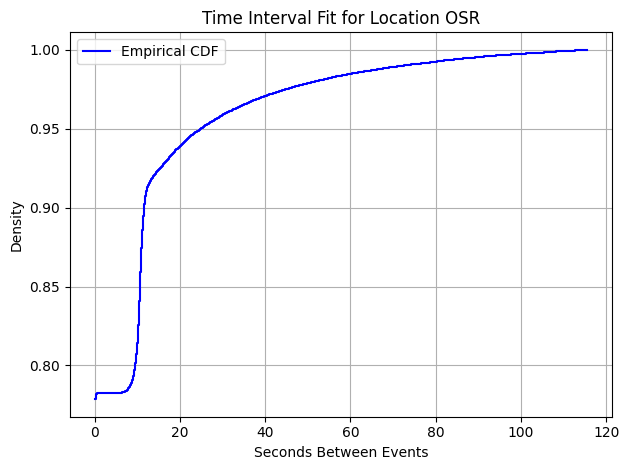

In [21]:
import seaborn as sns
import numpy as np

# Pick a location to visualize
lambda_hat = 1 / filtered_intervals.mean()

# Plot histogram with exponential fit
#sns.histplot(filtered_intervals, bins=300, kde=False, stat='density', label='Observed', color='skyblue')
sns.histplot(filtered_intervals, bins=500, stat='density', cumulative=True, element='step', fill=False, color='blue', label='Empirical CDF')

#x = np.linspace(1, upper_bound, 500)
#pdf = lambda_hat * np.exp(-lambda_hat * x)
#plt.plot(x, pdf, label=f'Exponential PDF (λ={lambda_hat:.4f})', color='red')
plt.title(f"Time Interval Fit for Location {loc}")
plt.xlabel("Seconds Between Events")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


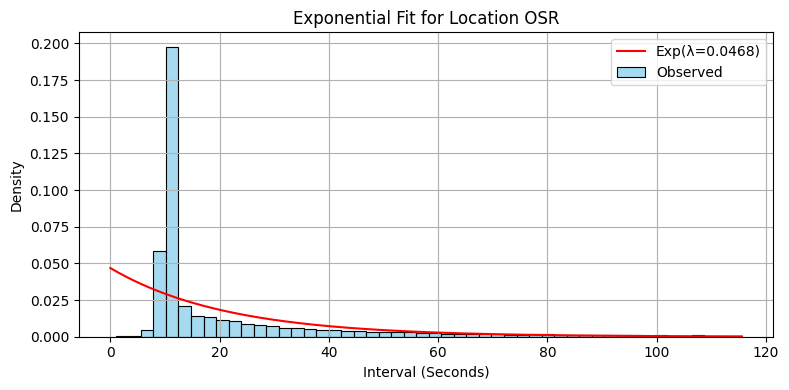

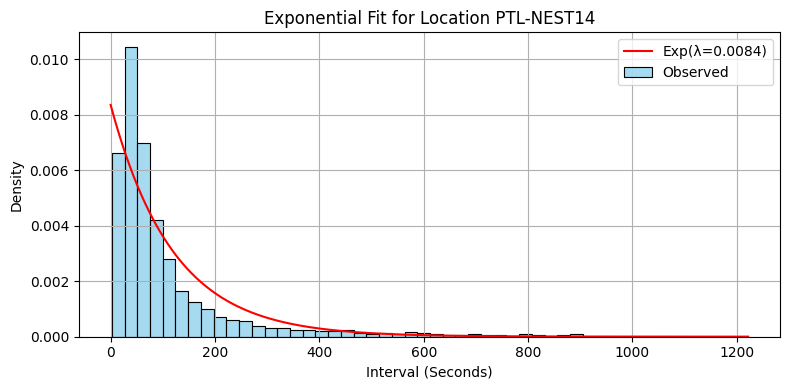

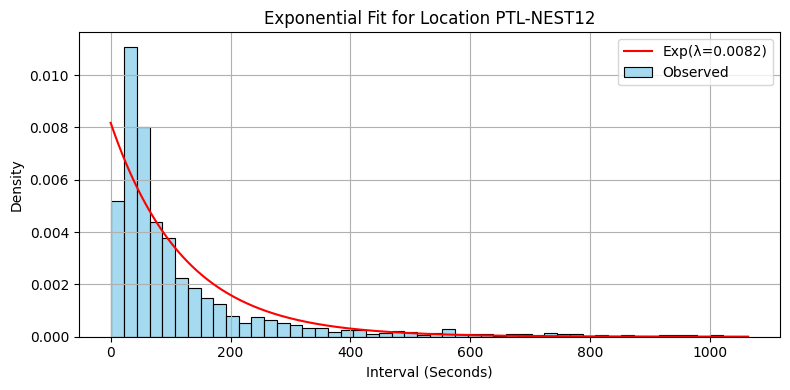

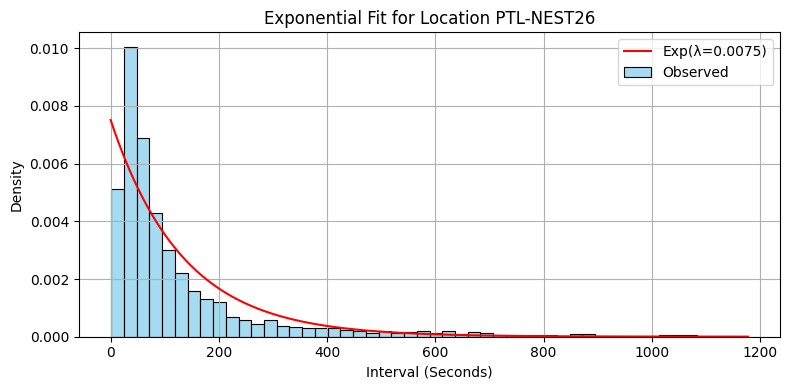

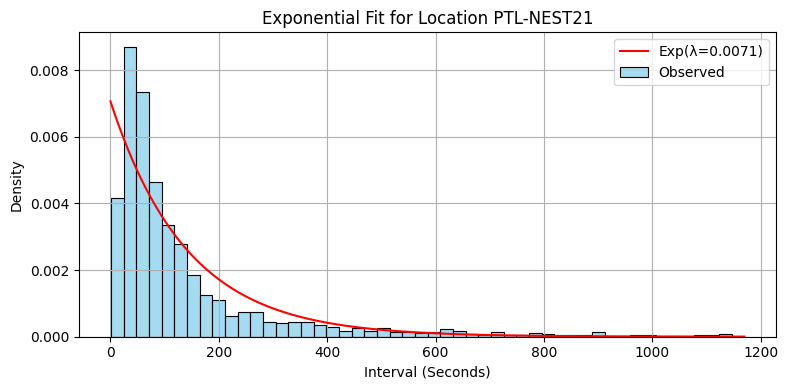

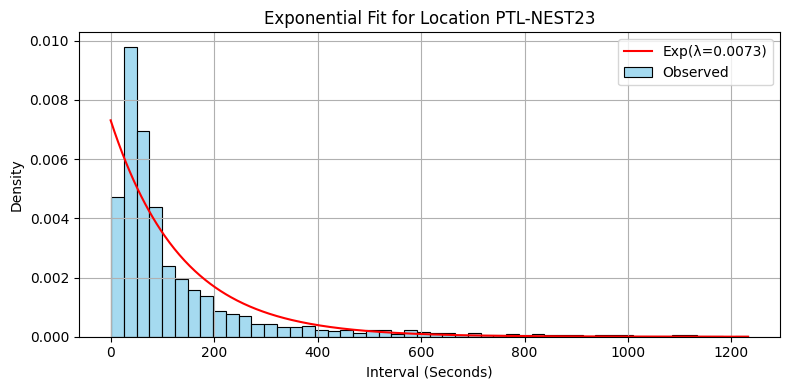

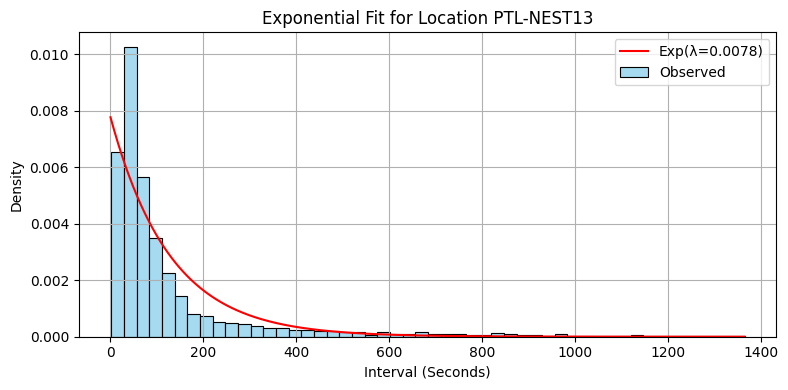

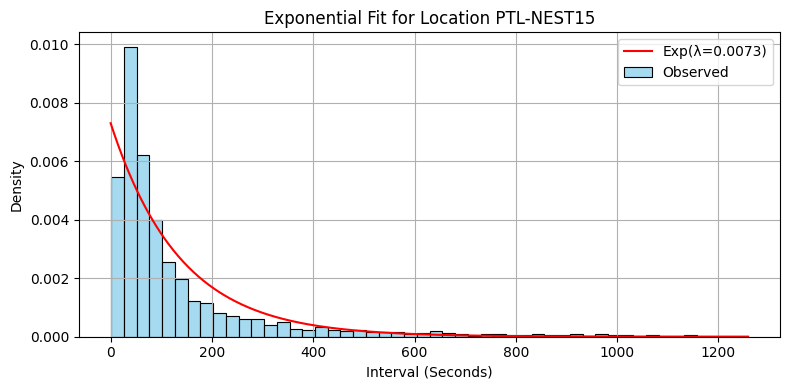

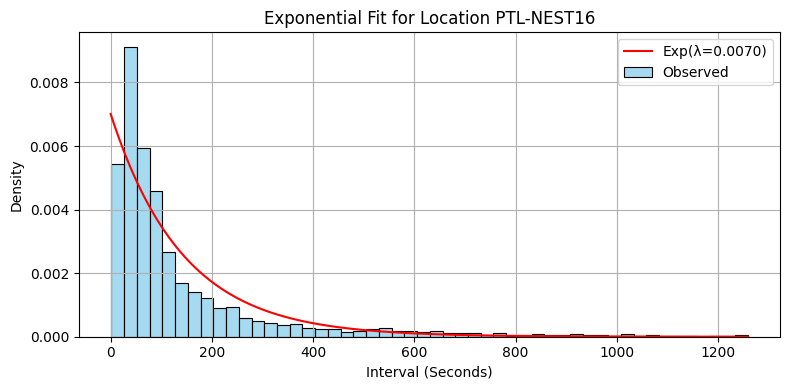

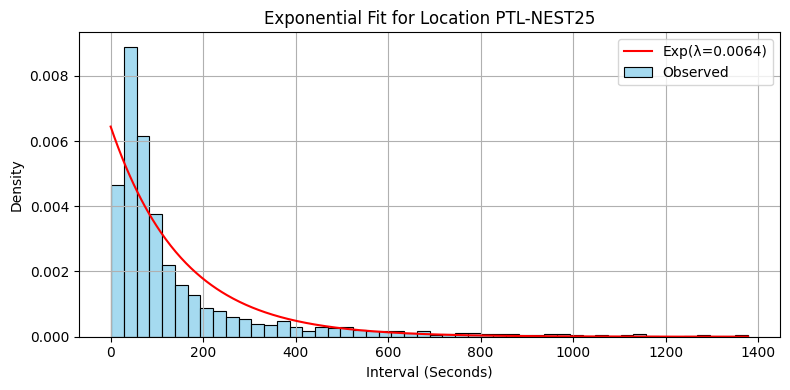

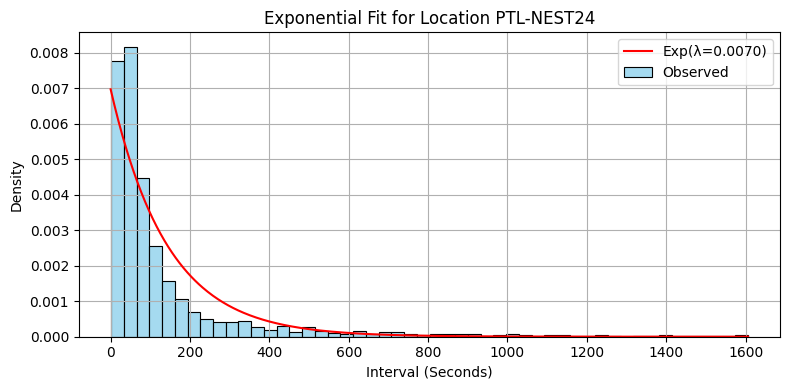

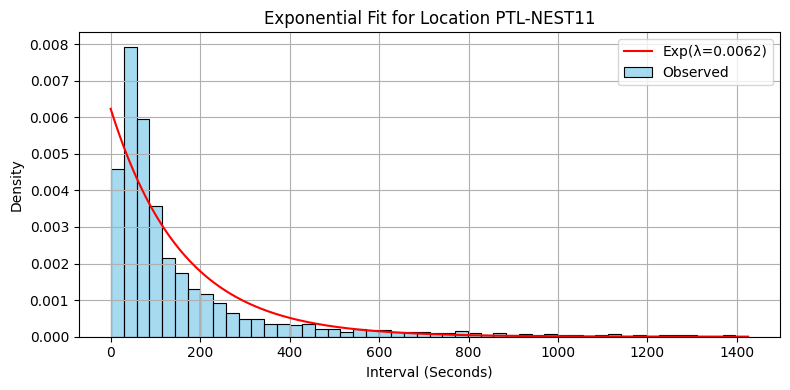

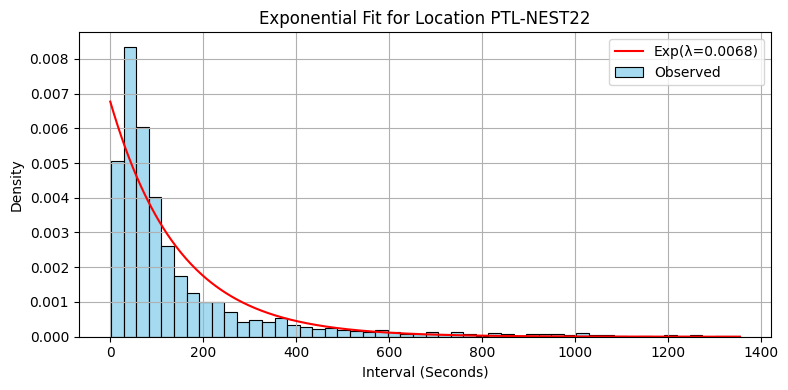

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Sort and compute intervals
df_sorted = df.sort_values(by=['Location code', 'Last Change Dt'])
df_sorted['Time Delta'] = df_sorted.groupby('Location code')['Last Change Dt'].diff()
df_sorted['Delta Seconds'] = df_sorted['Time Delta'].dt.total_seconds()

# Step 2: Get top 13 Location codes by row count
top_locations = df['Location code'].value_counts().head(13).index

# Step 3: Plot in loop
for loc in top_locations:
    df_loc = df_sorted[df_sorted['Location code'] == loc]
    upper_bound = df_loc['Delta Seconds'].quantile(0.99)

        # Filter out outliers
    intervals = df_loc['Delta Seconds'][
        (df_loc['Delta Seconds'] <= upper_bound) &
        (df_loc['Delta Seconds'] >= 1)
    ].dropna()


    if len(intervals) < 2:
        continue  # skip locations with too few intervals to plot

    lambda_hat = 1 / intervals.mean()

    # Plot
    plt.figure(figsize=(8, 4))
    sns.histplot(intervals, bins=50, stat='density', color='skyblue', label='Observed')

    x = np.linspace(0, intervals.max(), 500)
    pdf = lambda_hat * np.exp(-lambda_hat * x)
    plt.plot(x, pdf, color='red', label=f'Exp(λ={lambda_hat:.4f})')

    plt.title(f"Exponential Fit for Location {loc}")
    plt.xlabel("Interval (Seconds)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


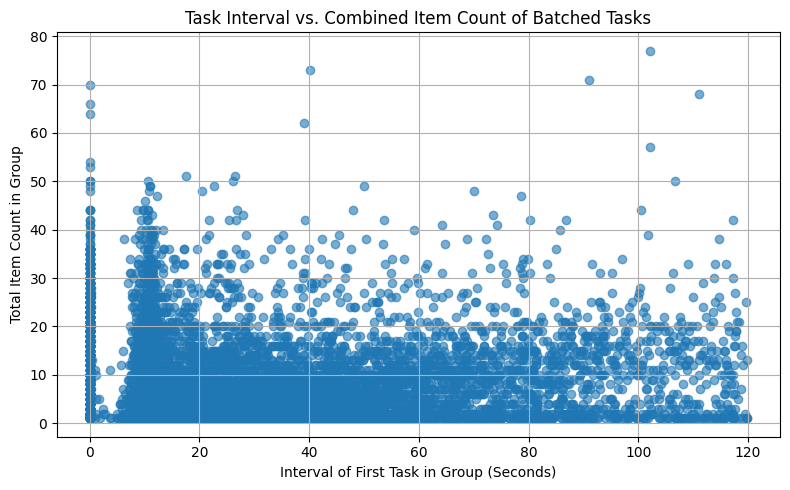

,Inventory Trans Number,Assc Inventory Trans Number,Task number,Sequence number,Creation Dt,Last Change Dt,Requester user code,Trans Type,Out in,Location code,...,Outbound order number,Outbound Order Line Number,Task list number,Picklist number,Picklist line number,Product code7,Time Delta,Delta Seconds,New Group,Group
1,114279215,114279214,14298324.0,1.0,2025-01-04 06:00:00.506999736,2025-01-04 06:00:00.527000005,24,Picking SKU,Incoming,OSR,...,1177094.0,4.0,NaN,2133194.0,4.0,NaN,0 days 00:00:00.440000251,0.440,False,0
2,114279217,114279216,14298325.0,1.0,2025-01-04 06:00:00.576999737,2025-01-04 06:00:00.587000183,24,Picking SKU,Incoming,OSR,...,1177094.0,5.0,NaN,2133194.0,5.0,NaN,0 days 00:00:00.060000178,0.060,False,0
3,114279219,114279218,14298326.0,1.0,2025-01-04 06:00:00.653000132,2025-01-04 06:00:00.679999708,24,Picking SKU,Incoming,OSR,...,1177094.0,6.0,NaN,2133194.0,6.0,NaN,0 days 00:00:00.092999525,0.093,False,0
4,114279221,114279220,14298327.0,1.0,2025-01-04 06:00:00.746999824,2025-01-04 06:00:00.760000155,5,Picking SKU,Incoming,OSR,...,1177094.0,7.0,NaN,2133194.0,7.0,NaN,0 days 00:00:00.080000447,0.080,False,0
5,114279223,114279222,14298328.0,1.0,2025-01-04 06:00:00.823000841,2025-01-04 06:00:00.853000303,24,Picking SKU,Incoming,OSR,...,1177094.0,8.0,NaN,2133194.0,8.0,NaN,0 days 00:00:00.093000148,0.093,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86365,117105618,117105617.0,14624574.0,1.0,2025-01-19 17:36:49.556999946,2025-01-19 17:36:49.559999823,43,Picking SKU,Incoming,OSR,...,1201390.0,45.0,NaN,2173406.0,7.0,NaN,0 days 00:00:00.076999931,0.077,False,19474
86366,117105620,117105619.0,14624576.0,1.0,2025-01-19 17:36:49.622999886,2025-01-19 17:36:49.622999886,43,Picking SKU,Incoming,OSR,...,1201390.0,47.0,NaN,2173406.0,9.0,NaN,0 days 00:00:00.063000063,0.063,False,19474
86367,117105622,117105621.0,14624577.0,1.0,2025-01-19 17:36:49.689999371,2025-01-19 17:36:49.702999703,43,Picking SKU,Incoming,OSR,...,1201390.0,1.0,NaN,2173406.0,10.0,NaN,0 days 00:00:00.079999817,0.080,False,19474
86368,117105624,117105623.0,14624579.0,1.0,2025-01-19 17:36:49.759999994,2025-01-19 17:36:49.762999880,43,Picking SKU,Incoming,OSR,...,1201390.0,3.0,NaN,2173406.0,12.0,NaN,0 days 00:00:00.060000177,0.060,False,19474


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# First ensure tasks are sorted by time
df_sorted_loc = loc_df.sort_values(by='Creation Dt').reset_index(drop=True)

# Label groups: new group when interval >= 1
df_sorted_loc['New Group'] = df_sorted_loc['Delta Seconds'] >= 1
df_sorted_loc['Group'] = df_sorted_loc['New Group'].cumsum()
df_sorted_loc = df_sorted_loc[df_sorted_loc['Delta Seconds']<120]

# Aggregate: get the interval of the first task in group and total item count
grouped = df_sorted_loc.groupby('Group').agg({
    'Delta Seconds': 'first',
    'Inventory Qty': 'sum'
}).reset_index()

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(grouped['Delta Seconds'], grouped['Inventory Qty'], alpha=0.6)
plt.xlabel('Interval of First Task in Group (Seconds)')
plt.ylabel('Total Item Count in Group')
plt.title('Task Interval vs. Combined Item Count of Batched Tasks')
plt.grid(True)
plt.tight_layout()
plt.show()

df_sorted_loc



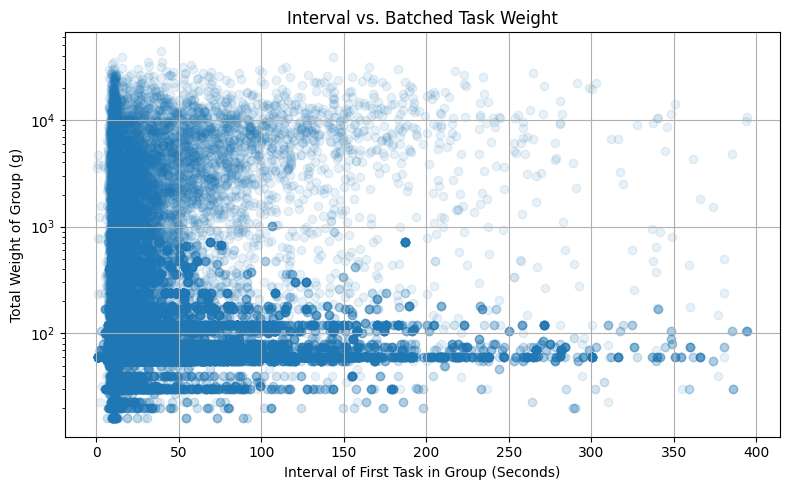

In [15]:
# Merge item weights into main dataframe
df_w = loc_df.merge(weights_df[['Item code', 'Weight(item)']], on='Item code', how='left')
df_w = df_w[['Delta Seconds','Weight(item)','Inventory Qty']].dropna()
df_w = df_w[df_w['Weight(item)']>0]
df_w = df_w[df_w['Inventory Qty']>0]


df_w['Total Weight'] = df_w['Weight(item)'] * df_w['Inventory Qty']
df_w['New Group'] = df_w['Delta Seconds'] >= 1
df_w['Group'] = df_w['New Group'].cumsum()

# Group-level: first interval and total weight
grouped = df_w.groupby('Group').agg({
    'Delta Seconds': 'first',
    'Total Weight': 'sum'
}).reset_index()
grouped = grouped[grouped['Delta Seconds']< 400]

#print(grouped[grouped['Total Weight'] < 100].head(20))

plt.figure(figsize=(8, 5))
plt.yscale('log')
plt.scatter(grouped['Delta Seconds'], grouped['Total Weight'], alpha=0.1)
plt.xlabel('Interval of First Task in Group (Seconds)')
plt.ylabel('Total Weight of Group (g)')
plt.title('Interval vs. Batched Task Weight')
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
orders = df[df['Outbound order number']==14569427]
order_size_count = df['Task number'].value_counts()
print(orders['Item code'].head())
#print(order_size_count)

duplicated_tasks = order_size_count[order_size_count > 1]
print(duplicated_tasks)


Series([], Name: Item code, dtype: int64)
Task number
14569427.0    30
14556582.0    26
14385390.0    25
14541545.0    19
14535858.0    19
              ..
14629013.0     2
14632729.0     2
14629560.0     2
14629027.0     2
14632162.0     2
Name: count, Length: 3961, dtype: int64


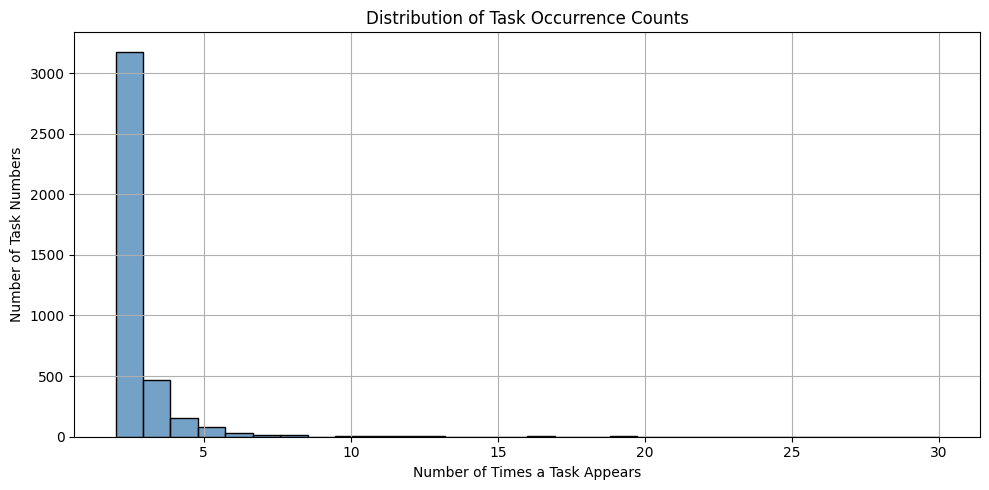

In [20]:
# Step 2: Plot the distribution of those counts
plt.figure(figsize=(10, 5))
sns.histplot(duplicated_tasks, bins=duplicated_tasks.max(), kde=False, color='steelblue')

plt.title('Distribution of Task Occurrence Counts')
plt.xlabel('Number of Times a Task Appears')
plt.ylabel('Number of Task Numbers')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
order_size_count = df['Outbound order number'].value_counts()
multi_item_tasks = order_size_count[order_size_count > 0]
print(multi_item_tasks)

# Get only items that appear in multi-item tasks
items_in_multi_item_tasks = df[df['Outbound order number'].isin(multi_item_tasks.keys())]['Item code'].unique()

# Now filter the original dataframe to only include those items
filtered_df = df[df['Item code'].isin(items_in_multi_item_tasks)]

# Build full task-item matrix with all tasks but filtered items
task_item_matrix = df[df['Item code'].isin(items_in_multi_item_tasks)] \
    .assign(present=1) \
    .pivot_table(index='Outbound order number', columns='Item code', values='present', fill_value=0) \
    .astype(int)

from scipy.sparse import csr_matrix

# Convert to sparse matrix
sparse_matrix = csr_matrix(task_item_matrix.values)

# Fast co-occurrence via sparse matrix multiplication
co_occurrence_sparse = sparse_matrix.T @ sparse_matrix

# Convert back to DataFrame with correct labels (optional)
co_occurrence_df = pd.DataFrame(
    co_occurrence_sparse.toarray(),
    index=task_item_matrix.columns,
    columns=task_item_matrix.columns
)

print(co_occurrence_df.head())

# Total tasks per item (including those where it's the only item!)
item_totals = df[df['Item code'].isin(items_in_multi_item_tasks)] \
    .groupby('Item code')['Outbound order number'].nunique()

print(item_totals)
# P(B|A) = # tasks with A and B / # tasks with A
conditional_probs = co_occurrence_df.div(item_totals, axis=1)



Outbound order number
1196171.0    936
1196172.0    773
1196173.0    613
1185801.0    480
1194447.0    454
            ... 
1200860.0      1
1201993.0      1
1200880.0      1
1183339.0      1
1200782.0      1
Name: count, Length: 24468, dtype: int64
Item code  0      1      2      3      4      5      6      7      8      \
Item code                                                                  
0             28      0      0      0      5      0      0      0      0   
1              0      1      0      0      0      0      0      0      0   
2              0      0      7      0      0      0      4      0      5   
3              0      0      0      4      0      2      0      0      0   
4              5      0      0      0     26      0      0      0      0   

Item code  9      ...  29391  29392  29393  29394  29395  29396  29397  29398  \
Item code         ...                                                           
0              0  ...      0      0      0      0      

In [22]:
import numpy as np
import pandas as pd

# Get the item labels
item_labels = conditional_probs.index

# Compute how often each item appears (diagonal of co-occurrence matrix)
item_counts = np.diag(co_occurrence_df.values)

# Find all (i, j) where co-occurrence > 1 and not diagonal
co_matrix = co_occurrence_df.values

n = co_matrix.shape[0]
mask_upper = np.triu(np.ones((n, n), dtype=bool), k=1)
i_idx, j_idx = np.where((co_matrix > 1) & mask_upper)

# Get counts
co_counts = co_matrix[i_idx, j_idx]

# Compute P(B | A)
p_b_given_a = co_counts / item_counts[i_idx]

# Optionally also compute P(A | B)
p_a_given_b = co_counts / item_counts[j_idx]

# Build DataFrame
conditional_probs = pd.DataFrame({
    'Item A': item_labels[i_idx],
    'Item B': item_labels[j_idx],
    'P(B|A)': p_b_given_a,
    'P(A|B)': p_a_given_b,
    'A' : np.diag(co_occurrence_df.values)[i_idx],
    'B' : np.diag(co_occurrence_df.values)[j_idx],
    'Co-occurrence': co_counts
})

# Sort by P(B|A), or by Co-occurrence if you prefer
conditional_probs = conditional_probs.sort_values(by='Co-occurrence', ascending=False)

# Preview top results
print(conditional_probs.head(20))
conditional_probs['Co-occurrence'].value_counts(bins=25)


        Item A  Item B    P(B|A)    P(A|B)    A    B  Co-occurrence
274862    2351    2663  0.885281  0.927438  462  441            409
257890    2107    2351  0.906977  0.844156  430  462            390
257871    2107    2170  0.855814  0.931646  430  395            368
8991        55     419  0.847222  0.933673  432  392            366
257908    2107    2663  0.851163  0.829932  430  441            366
249000    2009    2107  0.923885  0.818605  381  430            352
468981   13931   13935  0.967033  0.953930  364  369            352
262353    2170    2351  0.891139  0.761905  395  462            352
270166    2297    2351  0.935657  0.755411  373  462            349
79352      544    4965  0.887468  0.850490  391  408            347
249039    2009    2663  0.897638  0.775510  381  441            342
19156      110     415  0.858942  0.921622  397  370            341
249022    2009    2351  0.889764  0.733766  381  462            339
262370    2170    2663  0.840506  0.752834  395 

(1.592, 18.28]      461372
(18.28, 34.56]       22126
(34.56, 50.84]        8088
(50.84, 67.12]        3686
(67.12, 83.4]         2073
(83.4, 99.68]         1312
(99.68, 115.96]        808
(115.96, 132.24]       623
(132.24, 148.52]       409
(148.52, 164.8]        265
(164.8, 181.08]        207
(181.08, 197.36]       111
(197.36, 213.64]       100
(213.64, 229.92]        87
(229.92, 246.2]         60
(246.2, 262.48]         46
(262.48, 278.76]        34
(278.76, 295.04]        11
(295.04, 311.32]        10
(311.32, 327.6]          6
(343.88, 360.16]         5
(327.6, 343.88]          4
(360.16, 376.44]         3
(376.44, 392.72]         1
(392.72, 409.0]          1
Name: count, dtype: int64

In [23]:
from scipy.stats import hypergeom

# Only keep non-diagonal pairs with > 1 co-occurrence
n = co_occurrence_df.shape[0]
total_orders = df.shape[0]
mask_upper = np.triu(np.ones((n, n), dtype=bool), k=1)
i_idx, j_idx = np.where((co_occurrence_df.values > 1) & mask_upper)

# Co-occurrence and marginals
co_counts = co_occurrence_df.values[i_idx, j_idx]
a_counts = item_counts[i_idx]
b_counts = item_counts[j_idx]

# Compute hypergeometric p-values
p_values = hypergeom.sf(co_counts - 1, total_orders, a_counts, b_counts)

# Build result DataFrame
chance_assoc = pd.DataFrame({
    'Item A': item_labels[i_idx],
    'Item B': item_labels[j_idx],
    'Co-occurrence': co_counts,
    'Item A Count': a_counts,
    'Item B Count': b_counts,
    'P(chance)': p_values
})

# Optional: sort by strongest (lowest) p-values
chance_assoc = chance_assoc.sort_values(by='P(chance)', ascending=False)

print(chance_assoc.head(20))
chance_assoc['P(chance)'].value_counts(bins=25)



        Item A  Item B  Co-occurrence  Item A Count  Item B Count  P(chance)
8948        55     110              2           432           397   0.162401
19583      110    4965              2           397           408   0.148499
8990        55     415              2           432           370   0.145416
19180      110     544              2           397           391   0.138807
56359      415    4965              2           370           408   0.132754
55966      415     419              2           370           392   0.124463
55985      415     544              2           370           391   0.123949
82922      567    2351              2           305           462   0.118751
82943      567    2663              2           305           441   0.110039
9168        55    3247              2           432           308   0.108093
9170        55    3273              2           432           304   0.105783
274980    2351    5005              2           462           284   0.105620

(-0.001162, 0.0065]    497737
(0.0065, 0.013]          1843
(0.013, 0.0195]           698
(0.0195, 0.026]           352
(0.026, 0.0325]           251
(0.0325, 0.039]           163
(0.039, 0.0455]           128
(0.0455, 0.052]            91
(0.052, 0.0585]            46
(0.0585, 0.065]            34
(0.065, 0.0715]            29
(0.0715, 0.078]            20
(0.0844, 0.0909]           17
(0.078, 0.0844]            15
(0.0909, 0.0974]            8
(0.104, 0.11]               5
(0.0974, 0.104]             3
(0.123, 0.13]               2
(0.143, 0.149]              2
(0.13, 0.136]               1
(0.117, 0.123]              1
(0.156, 0.162]              1
(0.136, 0.143]              1
(0.11, 0.117]               0
(0.149, 0.156]              0
Name: count, dtype: int64

In [24]:
co_occurrence_sparse.setdiag(0)  # remove diagonal
co_occurrence_sparse.eliminate_zeros()

# Step 4: Convert to coordinate (COO) format to access nonzero elements
from scipy.sparse import coo_matrix
coo = co_occurrence_sparse.tocoo()
item_names = task_item_matrix.columns
# Step 5: Filter and show pairs with > 30 co-occurrences
result = pd.DataFrame({
    'Item A': item_names[coo.row],
    'Item B': item_names[coo.col],
    'Order Count': coo.data
})

result = result[result['Order Count'] > 30].sort_values(by='Order Count', ascending=False)

print(result)


         Item A  Item B  Order Count
1021356    2663    2351          409
1110338    2351    2663          409
953022     2351    2107          390
1021363    2107    2351          390
953027     2170    2107          368
...         ...     ...          ...
648565     3470    1324           31
1244097    3243    3259           31
1323888    5050    3495           31
3533173   21903   21909           31
1997137    3619    6211           31

[42564 rows x 3 columns]


In [25]:
# Group by Item code and count the number of unique Stock Product IDs
mapping_check = df.groupby('Creation Dt')['Last Change Dt'].nunique()

# Find Item codes that map to more than one Stock Product ID
inconsistent_items = mapping_check[mapping_check > 1]

# Show results
print(f"Total inconsistent items: {len(inconsistent_items)}")
print(inconsistent_items)


Total inconsistent items: 13
Creation Dt
2025-01-04 11:15:52.866999760    2
2025-01-07 06:18:53.960000515    2
2025-01-07 14:41:39.787000100    2
2025-01-08 15:40:09.972999894    2
2025-01-13 17:12:20.412999737    2
2025-01-14 07:50:19.100000267    2
2025-01-15 07:35:17.550000084    2
2025-01-16 06:41:49.473000208    2
2025-01-16 08:52:52.303000048    2
2025-01-16 13:04:29.142999690    2
2025-01-16 15:02:59.869999783    2
2025-01-18 13:42:03.020000169    2
2025-01-18 14:37:34.922999976    2
Name: Last Change Dt, dtype: int64


In [26]:
# Calculate the time difference
df['Time Difference'] = df['Last Change Dt'] - df['Creation Dt']

# Filter rows where the difference isn't zero
df_diff = df[df['Time Difference'] != pd.Timedelta(0)]

# Optional: sort by largest differences
df_diff = df_diff.sort_values(by='Time Difference', ascending=False)

# Display result
print(df_diff[['Time Difference']].head(40))

                 Time Difference
140034 0 days 00:00:00.327001095
43122  0 days 00:00:00.322999151
58811  0 days 00:00:00.279999988
42788  0 days 00:00:00.266999656
139984 0 days 00:00:00.260000350
15006  0 days 00:00:00.249999273
90183  0 days 00:00:00.240000080
35322  0 days 00:00:00.240000079
3842   0 days 00:00:00.234000317
48002  0 days 00:00:00.230000264
43598  0 days 00:00:00.220000441
91011  0 days 00:00:00.219999189
35652  0 days 00:00:00.216000389
126314 0 days 00:00:00.209999995
84802  0 days 00:00:00.203000058
89959  0 days 00:00:00.196999663
46472  0 days 00:00:00.196999663
91151  0 days 00:00:00.193000233
84826  0 days 00:00:00.189999725
85654  0 days 00:00:00.189999095
81249  0 days 00:00:00.173999508
49985  0 days 00:00:00.169999456
90219  0 days 00:00:00.164000315
125822 0 days 00:00:00.163999063
91017  0 days 00:00:00.163000772
88784  0 days 00:00:00.163000149
43752  0 days 00:00:00.160000263
89018  0 days 00:00:00.159999641
84463  0 days 00:00:00.157000377
42591  0 d

# Experiments for items in orders and such


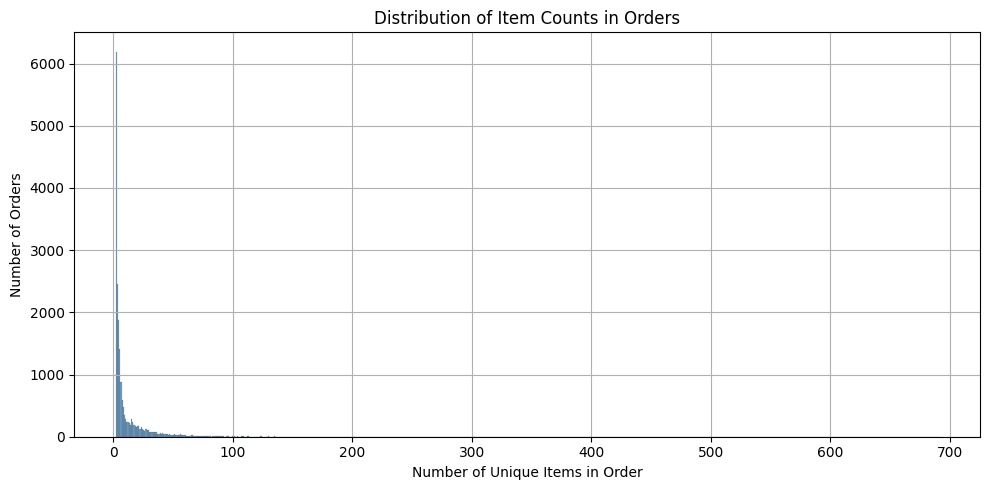

In [27]:
# plot the distribution of the number of items in orders
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

# data already loaded and converted

# Step 1: Count items per order
order_item_count = df.groupby('Outbound order number')['Item code'].nunique()
order_item_count = order_item_count[order_item_count > 1]
# Step 2: Plot the distribution of those counts
plt.figure(figsize=(10, 5))
sns.histplot(order_item_count, bins=order_item_count.max(), kde=False, color='steelblue')
plt.title('Distribution of Item Counts in Orders')
plt.xlabel('Number of Unique Items in Order')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.tight_layout()
plt.show()



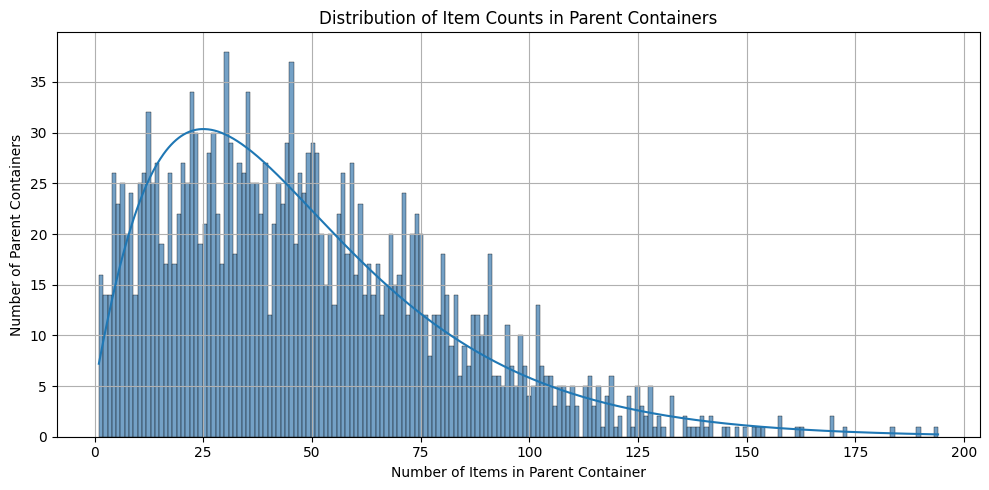

In [28]:
# plot item in the parent containers
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
loc = 'OSR'



fildered_df = df[df['Location code'] == loc].sort_values(by='Last Change Dt')
# Step 1: Count items parent container code
item_parent_count = fildered_df.groupby('Parent container code')['Inventory Qty'].sum()

res = stats.gamma.fit(item_parent_count)

# Step 3: Plot the distribution of those counts
plt.figure(figsize=(10, 5))
sns.histplot(item_parent_count, bins=item_parent_count.max(), kde=False, color='steelblue')
# plot the gamma fit also
x_fit = np.linspace(min(item_parent_count), max(item_parent_count), 1000)
pdf_fitted = stats.gamma.pdf(x_fit, res[0], loc=res[1], scale=res[2])
pdf_fitted = pdf_fitted * len(item_parent_count)
plt.plot(x_fit, pdf_fitted, label='Gamma')
plt.title('Distribution of Item Counts in Parent Containers')
plt.xlabel('Number of Items in Parent Container')
plt.ylabel('Number of Parent Containers')
plt.grid(True)
plt.tight_layout()
plt.show()

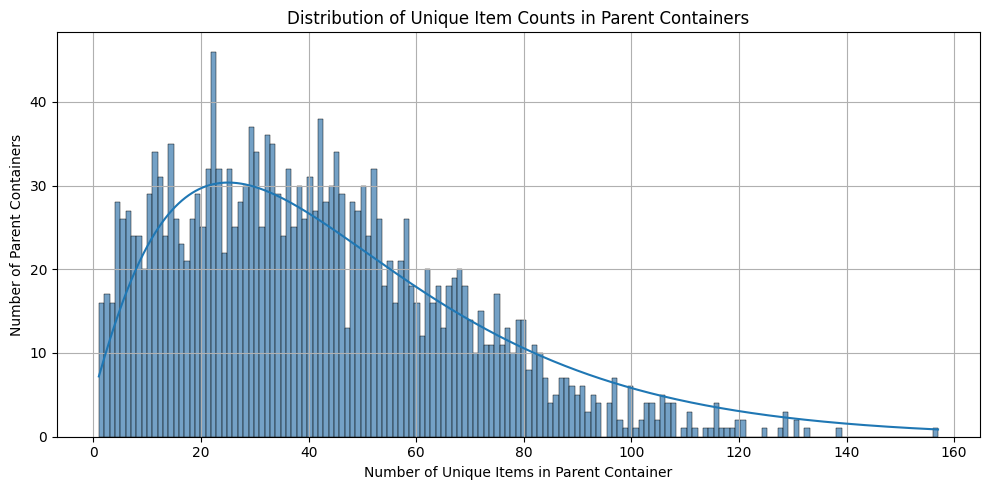

In [29]:
# plot the amount of diffrent items in the parent containers
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

loc = 'OSR'

filtered_df = df[df['Location code'] == loc].sort_values(by='Last Change Dt')
filtered_df = filtered_df[filtered_df['Inventory Qty'] > 0]

# Step 1: Count items parent container code
item_parent_count = filtered_df.groupby('Parent container code')['Item code'].nunique()
# Step 3: Plot the distribution of those counts
plt.figure(figsize=(10, 5))
sns.histplot(item_parent_count, bins=item_parent_count.max(), kde=False, color='steelblue')
x_fit = np.linspace(min(item_parent_count), max(item_parent_count), 1000)
pdf_fitted = stats.gamma.pdf(x_fit, res[0], loc=res[1], scale=res[2])
pdf_fitted = pdf_fitted * len(item_parent_count)
plt.plot(x_fit, pdf_fitted, label='Gamma')
plt.title('Distribution of Unique Item Counts in Parent Containers')
plt.xlabel('Number of Unique Items in Parent Container')
plt.ylabel('Number of Parent Containers')
plt.grid(True)
plt.tight_layout()

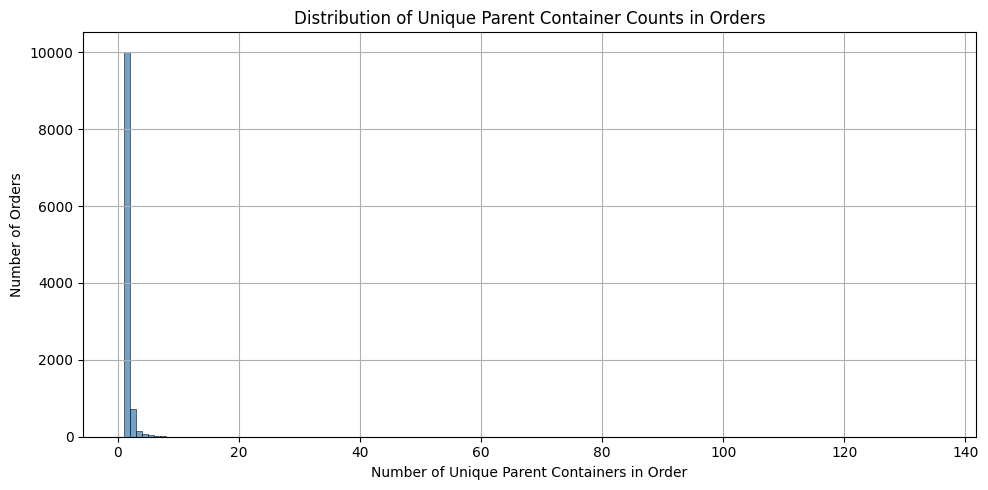

In [30]:
# amount of differnt parent containers that each order with more than 1 item has
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

loc = 'OSR'
filtered_df = df[df['Location code'] == loc].sort_values(by='Last Change Dt')

# Step 1: get amoutn of items per order
order_item_count = filtered_df.groupby('Outbound order number')['Item code'].nunique()
# Step 2: Filter to keep only those with more than 1 item
order_item_count = order_item_count[order_item_count > 1]

# Step 3: for all those orders get the amount of unique parent containers
order_parent_count = filtered_df[filtered_df['Outbound order number'].isin(order_item_count.index)].groupby('Outbound order number')['Parent container code'].nunique()
# Step 4: Plot the distribution of those counts
plt.figure(figsize=(10, 5))
sns.histplot(order_parent_count, bins=order_parent_count.max(), kde=False, color='steelblue')
plt.title('Distribution of Unique Parent Container Counts in Orders')
plt.xlabel('Number of Unique Parent Containers in Order')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.tight_layout()

#meestal komen als het meerder oders zijn in dezelfde tray! waarschijnlijk gerlateerd!

In [31]:
# are related items stored together?


In [32]:
print(order_parent_count.head())


Outbound order number
1174664.0    1
1174675.0    1
1174686.0    1
1174691.0    1
1174789.0    1
Name: Parent container code, dtype: int64


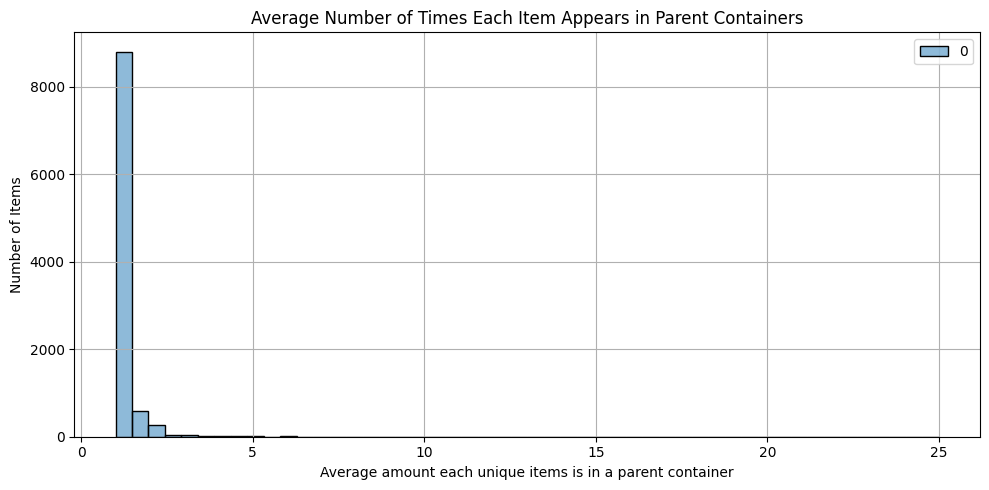

In [33]:
# how many times does each item by average comes in a parent container
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

loc = 'OSR'
filtered_df = df[df['Location code'] == loc].sort_values(by='Last Change Dt')

dictOfItems = {}


# for each parent container
for parent_container in filtered_df['Parent container code'].unique():
    # get the items in that parent container
    items_in_container = filtered_df[filtered_df['Parent container code'] == parent_container]
    # count the number of times each item appears
    item_counts = items_in_container.groupby('Item code')['Inventory Qty'].sum()
    # store the amount of times each item appears in the parent container
    for item, count in item_counts.items():
        if item not in dictOfItems:
            dictOfItems[item] = []
        dictOfItems[item].append(count)

# plot the average number of times each item appears in a parent container
averages = {item: np.mean(counts) for item, counts in dictOfItems.items()}
plt.figure(figsize=(10, 5))
sns.histplot(averages.values(), bins=50, kde=False, color='steelblue')
plt.title('Average Number of Times Each Item Appears in Parent Containers')
plt.xlabel('Average amount each unique items is in a parent container')
plt.ylabel('Number of Items')
plt.grid(True)
plt.tight_layout()
# bijna altijd komt elk item maar 1x voor in een container


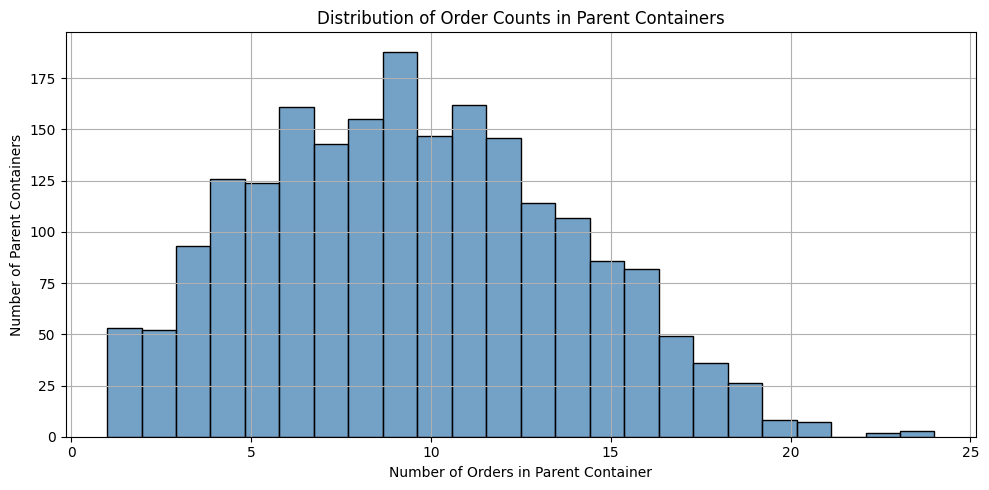

In [34]:
# how many orders does each tray have
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

loc = 'OSR'
filtered_df = df[df['Location code'] == loc].sort_values(by='Last Change Dt')

# Setp 1: count the amount of orders per parent container
tray_order_count = filtered_df.groupby('Parent container code')['Outbound order number'].nunique()
# Step 2: Plot the distribution of those counts
plt.figure(figsize=(10, 5))
sns.histplot(tray_order_count, bins=tray_order_count.max(), kde=False, color='steelblue')
plt.title('Distribution of Order Counts in Parent Containers')
plt.xlabel('Number of Orders in Parent Container')
plt.ylabel('Number of Parent Containers')
plt.grid(True)
plt.tight_layout()

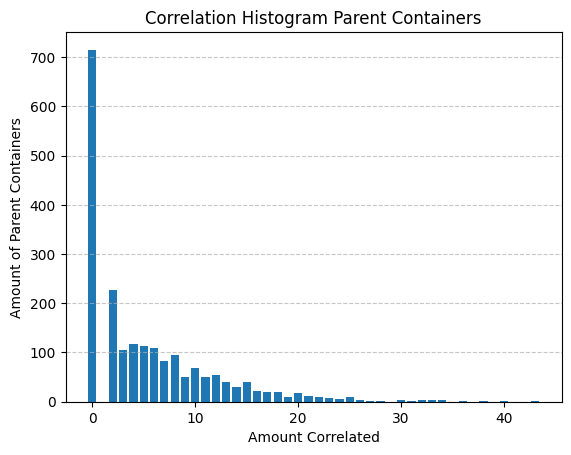

In [35]:
loc = 'OSR'
dict_with_counts = {}
filtered_df = df[df['Location code'] == loc].sort_values(by='Last Change Dt')

for parent_container in filtered_df['Parent container code'].unique():
    items_for_parent_container =  filtered_df[filtered_df['Parent container code'] == parent_container]['Item code'].unique()
    # if there aren't any items in items_for_parent_container, contineu
    if len(items_for_parent_container) <= 1:
        continue
# using the "result" dataframe, calculate the amount of pairs that have correlatoin

# Filter for rows where both items are in the list and Order Count > 30
    filtered = result[
     (result['Item A'].isin(items_for_parent_container)) &
     (result['Item B'].isin(items_for_parent_container)) &
     (result['Order Count'] > 30)
    ]

    # Get the unique items involved in these correlations
    correlated_items = pd.unique(filtered[['Item A', 'Item B']].values.ravel())
    # Count them
    count = len(correlated_items)
    # if the key count is not in the dict, init with zero
    if count not in dict_with_counts:
        dict_with_counts[count] = 0
    dict_with_counts[count] += 1

dict_with_counts

# plot the dict as a hist. the x axis is the key(count) the y axis is the amount of bins that have this count1

x = list(dict_with_counts.keys())   # amount_correlated
y = list(dict_with_counts.values()) # amount of parent boxes
plt.bar(x, y)
plt.xlabel('Amount Correlated')
plt.ylabel('Amount of Parent Containers')
plt.title('Correlation Histogram Parent Containers')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
# de items liggen random in de bakken.

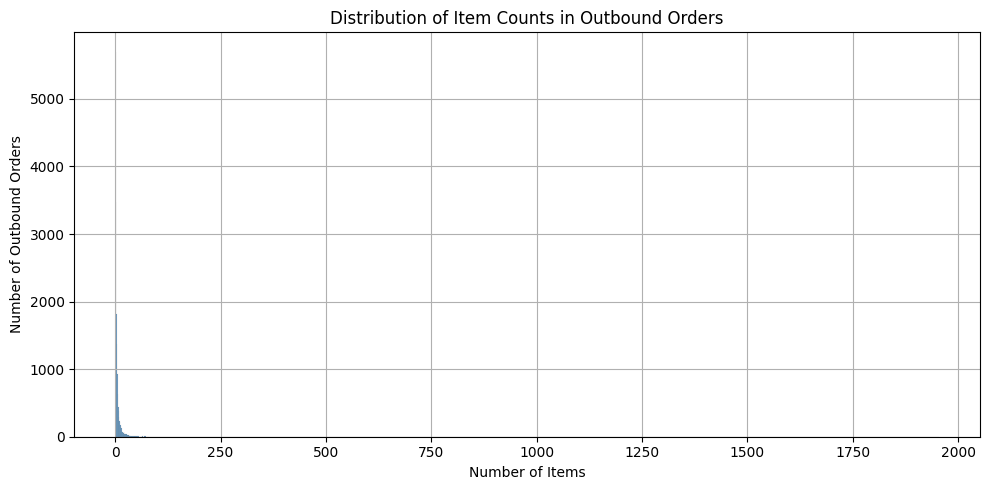

In [36]:
# plot of amount of items in each order
loc = 'OCR'
filtered_df = df[df['Location code'] == loc]

item_count = item_parent_count = fildered_df.groupby('Outbound order number')['Inventory Qty'].sum()
plt.figure(figsize=(10, 5))
sns.histplot(item_count, bins=item_count.max(), kde=False, color='steelblue')
plt.title('Distribution of Item Counts in Outbound Orders')
plt.xlabel('Number of Items')
plt.ylabel('Number of Outbound Orders')
plt.grid(True)
plt.tight_layout()



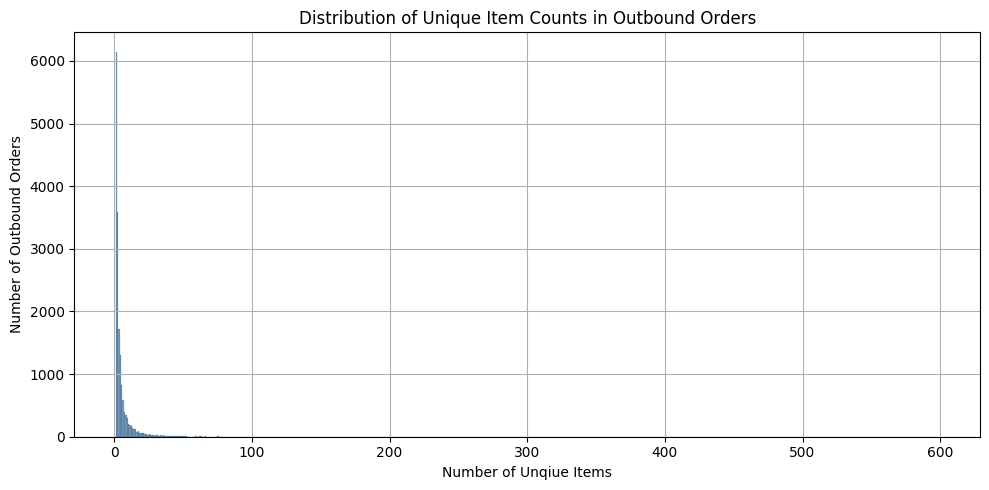

In [37]:
# plot the amountn of diffrent items in each order
loc = 'OCR'
filtered_df = df[df['Location code'] == loc]

item_count = item_parent_count = fildered_df.groupby('Outbound order number')['Item code'].nunique()
plt.figure(figsize=(10, 5))
sns.histplot(item_count, bins=item_count.max(), kde=False, color='steelblue')
plt.title('Distribution of Unique Item Counts in Outbound Orders')
plt.xlabel('Number of Unqiue Items')
plt.ylabel('Number of Outbound Orders')
plt.grid(True)
plt.tight_layout()


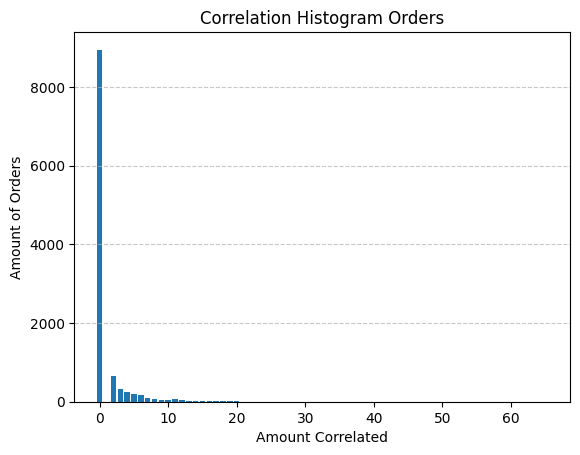

In [38]:
loc = 'OSR'
dict_with_counts = {}
filtered_df = df[df['Location code'] == loc].sort_values(by='Last Change Dt')

for outbound_order in filtered_df['Outbound order number'].unique():
    items_for_outbound_order =  filtered_df[filtered_df['Outbound order number'] == outbound_order]['Item code'].unique()
    # if there aren't any items in items_for_parent_container, contineu
    if len(items_for_outbound_order) <= 1:
        continue
# using the "result" dataframe, calculate the amount of pairs that have correlatoin

# Filter for rows where both items are in the list and Order Count > 30
    filtered = result[
     (result['Item A'].isin(items_for_outbound_order)) &
     (result['Item B'].isin(items_for_outbound_order)) &
     (result['Order Count'] > 30)
    ]

    # Get the unique items involved in these correlations
    correlated_items = pd.unique(filtered[['Item A', 'Item B']].values.ravel())
    # Count them
    count = len(correlated_items)
    # if the key count is not in the dict, init with zero
    if count not in dict_with_counts:
        dict_with_counts[count] = 0
    dict_with_counts[count] += 1

dict_with_counts

# plot the dict as a hist. the x axis is the key(count) the y axis is the amount of bins that have this count1

x = list(dict_with_counts.keys())   # amount_correlated
y = list(dict_with_counts.values()) # amount of parent boxes
plt.bar(x, y)
plt.xlabel('Amount Correlated')
plt.ylabel('Amount of Orders')
plt.title('Correlation Histogram Orders')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
# binnen een order: eig ook nooit correlatie

In [39]:
# laatste chatgpt check van de correlaties
loc = 'OSR'
filtered_df = df[df['Location code'] == loc]
transactions_all = filtered_df[['Outbound order number', 'Item code']].groupby('Outbound order number')['Item code'].apply(list).tolist()
# if the second list  needs to have 2 item minmuum
transactions = []
for transaction in transactions_all:
    if len(transaction) <= 1:
        continue
    transactions.append(transaction)
transactions

[[723,
  1000,
  5409,
  1527,
  8640,
  7073,
  3678,
  6542,
  6446,
  4364,
  1576,
  4412,
  5839,
  1119,
  8200,
  12722,
  3456],
 [10728, 3108, 3025, 4344, 7540, 6249, 10119, 6443, 6055, 8010, 11073, 12389],
 [4817, 4358],
 [5409, 1527, 4364, 4308, 10292, 4040, 4285, 8177, 494, 6135, 3428],
 [467, 5024],
 [7073,
  494,
  7612,
  4412,
  1527,
  11080,
  4364,
  1576,
  5479,
  5323,
  1000,
  5409,
  1000],
 [2549, 8585, 4378, 4378],
 [12798,
  7870,
  577,
  774,
  4818,
  1819,
  10984,
  5350,
  8592,
  4253,
  6321,
  10088,
  4250,
  12093,
  691],
 [9626, 13043, 7639, 9810, 9467, 10919, 7593, 576, 812, 12940],
 [19985, 6714, 17887, 339, 10807],
 [8378, 18185, 4597, 809, 593],
 [7544,
  4631,
  1191,
  1200,
  616,
  1229,
  1386,
  1442,
  1129,
  655,
  685,
  720,
  760,
  626,
  563,
  7349,
  655],
 [4873, 1297, 1276, 5244, 8268, 7506, 1190, 1394, 1070, 947, 7935],
 [11080, 1119, 5479],
 [1152, 9505],
 [416, 7674, 3382],
 [7947, 3892, 6422],
 [874, 5176, 564, 9142, 77

In [40]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Convert transactions to one-hot encoded format
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
# Apply Apriori algorithm
frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)
frequent_itemsets

ModuleNotFoundError: No module named 'mlxtend'

In [ ]:

# Generate rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# View results
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

  antecedents consequents   support  confidence        lift
0      (1688)      (2853)  0.005498    0.847222  103.295940
1      (2853)      (1688)  0.005498    0.670330  103.295940
2      (2796)      (2605)  0.005047    0.875000  156.582661
3      (2605)      (2796)  0.005047    0.903226  156.582661
4      (3313)      (2676)  0.005858    0.560345   82.893678
5      (2676)      (3313)  0.005858    0.866667   82.893678
6      (3313)      (4462)  0.005858    0.560345   92.791431
7      (4462)      (3313)  0.005858    0.970149   92.791431
8     (29171)     (29101)  0.005137    0.966102  164.906128
9     (29101)     (29171)  0.005137    0.876923  164.906128


In [ ]:
# TODO: correlatiescores erbij (ik wil weten wat is de correlatie tussen items in dzelfde parent container)
# TODO: zelfde behandeling als parent containers voor de orders.

In [ ]:
import pandas as pd
loc = 'OSR'
filtered_df = df[df['Location code'] == loc].sort_values(by='Last Change Dt')

parent_containers = df['Parent container code'].unique()
parent_container = parent_containers[0]
print(parent_container)
# get all records that have tha tparent container
parent_container_df = filtered_df[filtered_df['Parent container code'] == parent_container]
parent_container_df

In [ ]:
import pandas as pd
loc = 'OSR'
filtered_inventory_df = inventory_info_df

parent_container = 50753
# get all records that have tha tparent container
parent_container_df = filtered_inventory_df[filtered_inventory_df['Parent container code'] == parent_container]
parent_container_df
# niet elke parent container staat hier in! dus geen idee wat we hier met zijn

In [ ]:
normal_parent_container_codes = df['Parent container code'].unique()
inventory_parent_container_codes = inventory_info_df['Parent container code'].unique()
# get the intersection
intersection = set(normal_parent_container_codes).intersection(inventory_parent_container_codes)
print(len(intersection))

In [ ]:
print(len(df['Parent container code'].unique()))

<Axes: xlabel='Interval', ylabel='Density'>

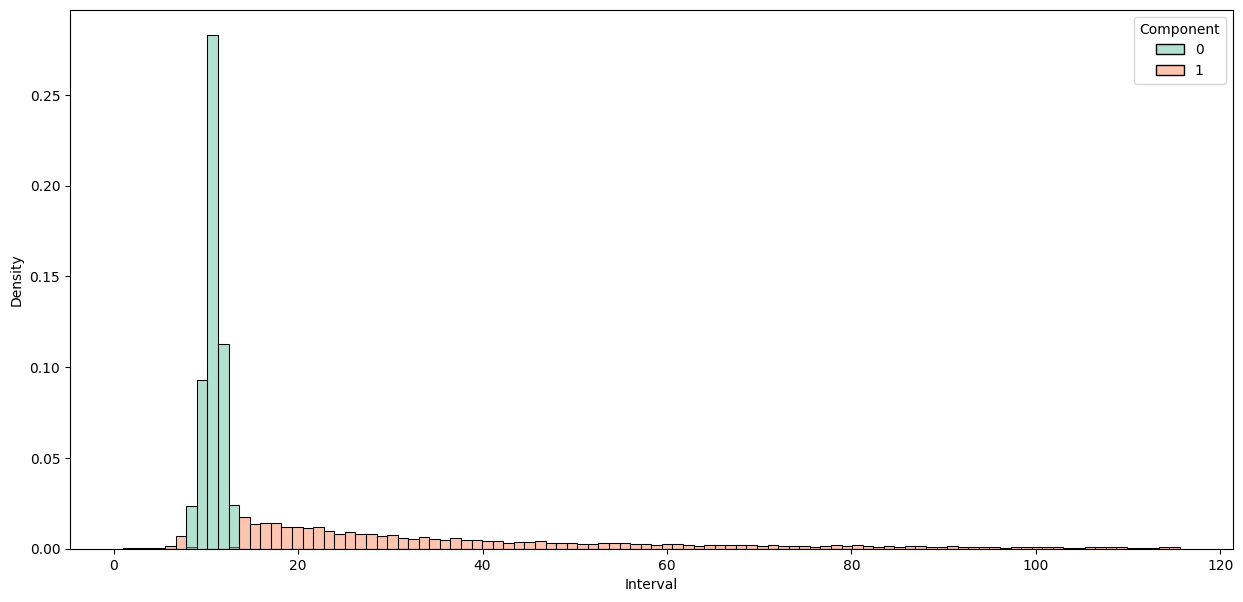

In [42]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Reshape required for scikit-learn
fixed_intervals = filtered_intervals#[filtered_intervals<=20].dropna()
X = fixed_intervals.values.reshape(-1, 1)

# Fit GMM with 2 components
gmm = GaussianMixture(n_components=2)
gmm.fit(X)

# Predict which component each interval belongs to
labels = gmm.predict(X)

# Add to your DataFrame for exploration
intervals_df = pd.DataFrame({'Interval': fixed_intervals.values, 'Component': labels})

plt.figure(figsize=(15, 7))
sns.histplot(data=intervals_df, x='Interval', hue='Component', bins=100, stat='density', palette='Set2')



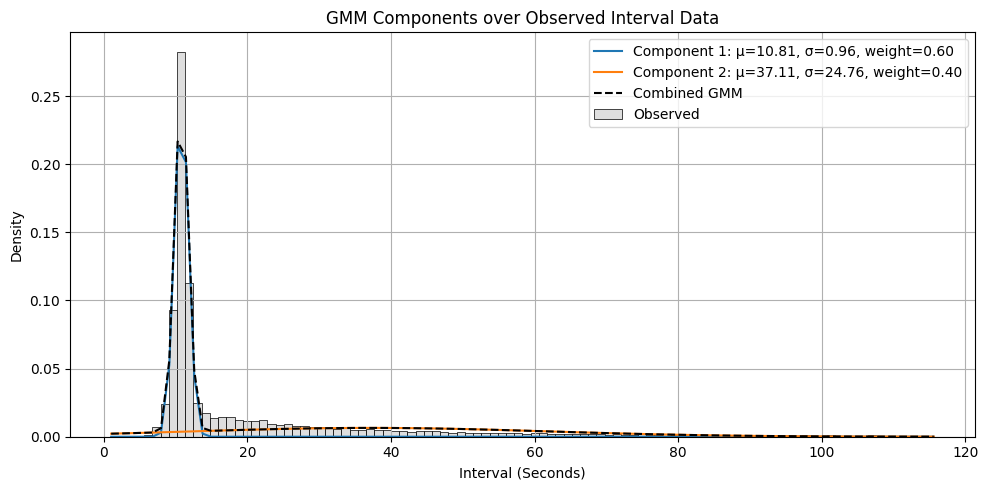

In [43]:
# Extract parameters
weights = gmm.weights_         # Mixing weights
means = gmm.means_.flatten()   # Means of Gaussians
stds = np.sqrt(gmm.covariances_).flatten()  # Standard deviations

# Range for plotting PDFs
x = np.linspace(X.min(), X.max(), 100)

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(filtered_intervals, bins=100, stat='density', color='lightgray', label='Observed')

# Plot each Gaussian component
for i in range(len(weights)):
    pdf = weights[i] * (1 / (stds[i] * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - means[i]) / stds[i])**2)
    plt.plot(x, pdf, label=f'Component {i+1}: μ={means[i]:.2f}, σ={stds[i]:.2f}, weight={weights[i]:.2f}')

# Optional: overlay the combined GMM fit
combined_pdf = sum(
    weights[i] * (1 / (stds[i] * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - means[i]) / stds[i])**2)
    for i in range(len(weights))
)
plt.plot(x, combined_pdf, 'k--', label='Combined GMM')

# Labels
plt.title("GMM Components over Observed Interval Data")
plt.xlabel("Interval (Seconds)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

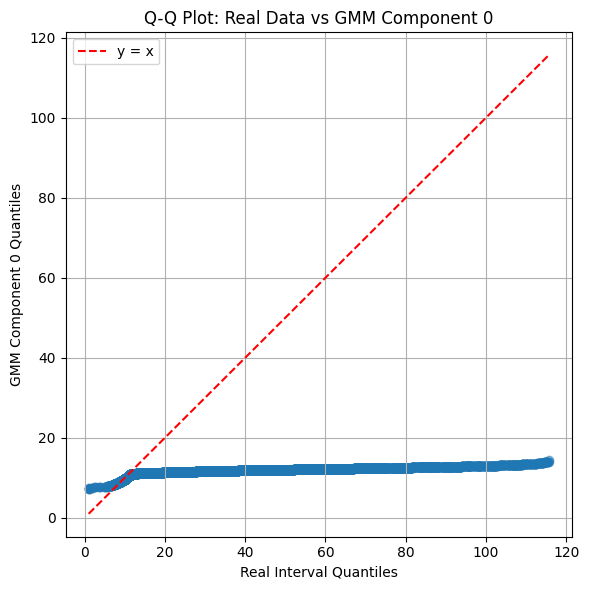

In [44]:

# Extract the parameters of the first component (index 0)
mean_0 = gmm.means_[0, 0]
std_0 = np.sqrt(gmm.covariances_[0, 0])

# Generate 1000 samples from just this Gaussian

samples_0 = np.random.normal(loc=mean_0, scale=std_0, size=len(fixed_intervals))


# Sort both sets
sorted_real = np.sort(fixed_intervals.values)
sorted_synth = np.sort(samples_0)

# Q-Q plot
plt.figure(figsize=(6, 6))
plt.scatter(sorted_real, sorted_synth, alpha=0.5)
plt.plot([sorted_real.min(), sorted_real.max()],
         [sorted_real.min(), sorted_real.max()], 'r--', label='y = x')

plt.xlabel('Real Interval Quantiles')
plt.ylabel('GMM Component 0 Quantiles')
plt.title('Q-Q Plot: Real Data vs GMM Component 0')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Get the posterior probabilities for each interval
probs = gmm.predict_proba(fixed_intervals.values.reshape(-1, 1))

# Probability of being in component 1 (second component)
p_component1 = probs[:, 1]

# Choose a threshold (e.g., > 0.9 confidence it's from component 1)
mask_component1 = p_component1 > 0.5

# Filter intervals that are likely from component 1
component1_intervals = fixed_intervals[mask_component1]


In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(component1_intervals, bins=100, stat='density', color='orange', label='Likely Component 1')
plt.title("Intervals Likely from GMM Component 1")
plt.xlabel("Interval (Seconds)")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import expon, poisson, chi2, kstest

# Try fitting exponential
lambda_hat = 1 / component1_intervals.mean()
_, p_exp = kstest(component1_intervals, 'expon', args=(0, 1/lambda_hat))

# Try fitting chi-squared
df_hat = 2 * lambda_hat * component1_intervals.mean()  # rough heuristic
_, p_chi2 = kstest(component1_intervals, 'chi2', args=(df_hat,))

print(f"Exponential fit p-value: {p_exp:.4f}")
print(f"Chi-squared fit p-value: {p_chi2:.4f}")


In [ ]:

# Sort both datasets
sorted_subset = np.sort(component1_intervals.values)
sorted_full = np.sort(fixed_intervals.values)

# Match sizes (trim longer one)
min_len = min(len(sorted_subset), len(sorted_full))
sorted_subset = sorted_subset[:min_len]
sorted_full = sorted_full[:min_len]

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(sorted_full, sorted_subset, alpha=0.5, label="Q-Q Points")
plt.plot([sorted_full.min(), sorted_full.max()],
         [sorted_full.min(), sorted_full.max()], 'r--', label='y = x')

plt.xlabel("Quantiles of Full Dataset")
plt.ylabel("Quantiles of Component 1 Intervals")
plt.title("Q-Q Plot: Component 1 vs Full Dataset")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
